In [1]:
from transformers import Speech2TextFeatureExtractor, Speech2TextModel
import torch
import torch.nn.functional as F
import torchaudio
import numpy as np

from auditory_cortex.regression import transformer_regression
from auditory_cortex.dataset import Neural_Data

dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
# dir = '/Users/akshita/Documents/Research/Makin/data'
subject = '200206'
neural_data = Neural_Data(dir, subject)


model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")
feature_extractor = Speech2TextFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")
reg = transformer_regression(dir, subject)

for param in model.parameters():
    param.requires_grad = False

sig = torch.nn.Sigmoid()

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/akamsali/anaconda3/envs/research_env/lib/pyt

In [2]:
def get_beta_eta(sent=[1], layer=0):
    # train_list = np.arange(1,451).tolist()
    z_vals_train, n_vals_train = reg.get_layer_values_and_spikes(layer=layer, win=80, sent_list=sent)
    # print(z_vals_train.shape, n_vals_train.shape)
    beta = np.linalg.solve(z_vals_train.T.dot(z_vals_train), (z_vals_train.T).dot(n_vals_train))
    return beta, n_vals_train, z_vals_train

In [3]:
layers = ["encoder.conv.conv_layers.0","encoder.conv.conv_layers.1","encoder.layers.0.fc2",
			"encoder.layers.1.fc2","encoder.layers.2.fc2","encoder.layers.3.fc2",
			"encoder.layers.4.fc2","encoder.layers.5.fc2","encoder.layers.6.fc2",
			"encoder.layers.7.fc2","encoder.layers.8.fc2","encoder.layers.9.fc2"]

In [19]:
from gradient_extraction.get_gradients import GetGradient

aud = neural_data.audio(0)
sent_list = np.arange(1, 499).tolist()
layer = 3
betas, _ , _ =  get_beta_eta(sent=sent_list, layer=layer)
betas = torch.tensor(betas, dtype=torch.float32)

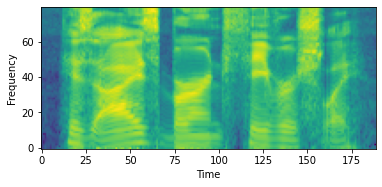

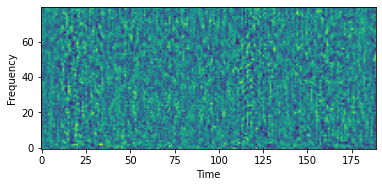

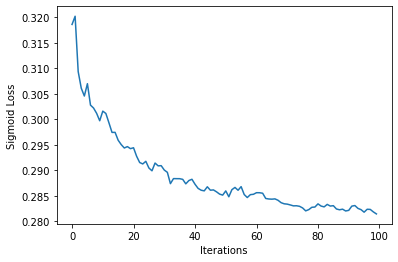

In [20]:
spect = feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features
optimizer = torch.optim.Adam([spect], lr=10)
get_opt_input = GetGradient(model, optimizer)

get_opt_input.get_opt_input(spect, betas, layers[layer], iterations=100)

# modified = dream(spect, model, "encoder.conv.conv_layers.0", iterations=10, lr=10)
with torch.no_grad():
    # modified.squeeze_(0)``
    spect.squeeze_(0)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features.squeeze_(0).detach().numpy().T)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Frequency")
# plt.show()
plt.figure()
plt.imshow(spect.detach().numpy().T)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.plot(get_opt_input.loss_list)
plt.xlabel("Iterations")
plt.ylabel("Sigmoid Loss")
plt.show()

In [15]:
spect.grad

tensor([[[ 3.2466e-10, -3.4564e-13, -8.4093e-12,  ..., -2.7338e-11,
           5.5835e-11,  7.6429e-11],
         [ 3.4489e-11, -3.7210e-10, -9.6085e-12,  ..., -1.0627e-11,
           1.5007e-10,  2.9191e-10],
         [ 1.5305e-10, -4.5525e-10, -3.8771e-10,  ...,  5.1351e-11,
           2.7825e-11,  8.7100e-11],
         ...,
         [ 4.5252e-10, -2.2161e-10, -2.3195e-10,  ..., -1.1289e-10,
          -9.4863e-11, -1.1198e-10],
         [ 1.6457e-10, -9.7323e-11, -2.1815e-10,  ..., -1.2138e-11,
           8.6876e-12, -2.4504e-11],
         [ 1.1182e-10, -1.1355e-10, -9.7091e-11,  ..., -9.1981e-13,
           8.2009e-12,  4.4412e-12]]])

In [6]:
s = np.abs(spect.detach().numpy())
s.shape

(1, 180, 80)

In [7]:
import librosa

audio_from_loss_prop = librosa.griffinlim(s)
audio_from_loss_prop.shape

ValueError: Invalid number of FFT data points (0) specified.

In [ ]:
# plt.plot(audio_from_loss_prop)
plt.plot(audio_from_loss_prop)

In [ ]:
y = aud
S = np.abs(librosa.stft(y))
# Invert using Griffin-Lim
y_inv = librosa.griffinlim(S)
# Invert without estimating phase
y_istft = librosa.istft(S)

# fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
# librosa.display.waveshow(y, sr=sr, color='b', ax=ax[0])
plt.plot(y)
plt.title("Orig")
plt.figure()
plt.plot(y_inv)
plt.title("GriffinLim")
plt.figure()
plt.plot(y_istft)
plt.title("ISTFT")